This notebook shows how you can force all your CPU cores to come alive. 
Most modules in python run on only 1 core of your comuter so if you have a multicore CPU, a significant portion of your processing power is sitting idle and your code would not be running as fast it should.

I am using a specific example of hyperparameter tuning for the XGB model, but this method is applicable to any problem. the general idea is the same

In [10]:
from multiprocessing import Process, current_process
import sys,os,concurrent.futures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pwd


/home/nightking


In [2]:
#CAnt remember where this sample dataset came from. One udemy tutorial sha
df = pd.DataFrame({
    'R&D Spend' : [165349.2,162597.7,153441.51,144372.41,142107.34,131876.9,134615.46,130298.13,120542.52,123334.88,101913.08,100671.96,93863.75,91992.39,119943.24,114523.61,78013.11,94657.16,91749.16],
    'Admin' : [136897.8,151377.59,101145.55,118671.85,91391.77,99814.71,147198.87,145530.06,148718.95,108679.17,110594.11,91790.61,127320.38,135495.07,156547.42,122616.84,121597.55,145077.58,114175.79],
    'Profit' : [192261.83,191792.06,191050.39,182901.99,166187.94,156991.12,156122.51,155752.6,152211.77,149759.96,146121.95,144259.4,141585.52,134307.35,132602.65,129917.04,126992.93,125370.37,124266.9]
})

In [3]:
df.head()

,R&D Spend,Admin,Profit
0,165349.20,136897.80,192261.83
1,162597.70,151377.59,191792.06
2,153441.51,101145.55,191050.39
3,144372.41,118671.85,182901.99
4,142107.34,91391.77,166187.94


In [4]:
X = df[['R&D Spend', 'Admin']]
y = df[['Profit']]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2018)


What I want to do is to find the best "n_estimator" parameter for RF. of course you can try different values one by one or you can run grid search but thats annoyingly slow. this is a hack but it works with a bit of tuning.

In [7]:
#I created an array to hold the tree number i would pass to the 'n_estimators' parameter. 
#Say I already have an idea that the optimum parameter is within 10 and 1000. I want to increase in steps of 50
value = []
for i in range(10,1000,10):
    value.append(i)


In [8]:
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

#Helper function
def mdl(x):
    regressor = xgb.XGBRegressor(n_estimators=x,learning_rate=0.1,random_state=1)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    return regressor.score(X_test,y_test)
#Yes, the score function takes in the test dataset and compares the results. Again don't know thte theory 
#But it returns a value between 0 and 1 where higher is better.

Calculating:  10 Result:  -6.697986348968629
Calculating:  20 Result:  -0.5579230495355425
Calculating:  30 Result:  0.3870663507526847
Calculating:  40 Result:  0.6095762518212652
Calculating:  50 Result:  0.6858275403650672
Calculating:  60 Result:  0.70031224943916
Calculating:  70 Result:  0.705021549287917
Calculating:  80 Result:  0.7058361164147802
Calculating:  90 Result:  0.7078567538460697
Calculating:  100 Result:  0.7091697734224021
Calculating:  110 Result:  0.7103489950979269
Calculating:  120 Result:  0.7099373448091849
Calculating:  130 Result:  0.7093869755298285
Calculating:  140 Result:  0.7095141558863793
Calculating:  150 Result:  0.7094373358284705
Calculating:  160 Result:  0.7094808939672018
Calculating:  170 Result:  0.7093375021031172
Calculating:  180 Result:  0.7091045845805586
Calculating:  190 Result:  0.7090129563326939
Calculating:  200 Result:  0.7089498831498237
Calculating:  210 Result:  0.7089551022201035
Calculating:  220 Result:  0.7089363545349354

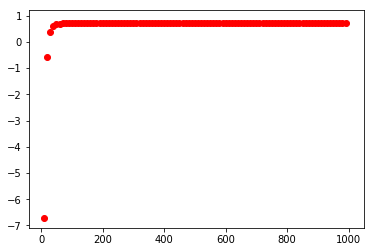

In [26]:
#Process pool executor class.
#Paralleling to speed up execution time
#At the end I decided to view the results on a plot as to gain insight into where the best performance is.
#Notice i'm using the r2 score as a measure of performance which the helper function returns. 
#Higher is better
with concurrent.futures.ProcessPoolExecutor() as executor:
    params = value 
    for x, y in zip(params, executor.map(mdl, params)):
        print('Calculating: ',x, 'Result: ',y)
        plt.scatter(x,y, color = 'red')


The process pool executor class is what does all the magic here

